# Introduction

In the first portion of this assignment 3 walkthrough, we rely on a popular NLP library [spaCy](https://spacy.io/) to create knowledge graphs.

In order to do this, we use the gramatical rules about sentence composition encoded in spaCy.

We begin by downloading the English lexicon.


In [2]:
! python -m spacy download en_core_web_lg

2023-11-27 02:12:47.136284: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 02:12:47.136360: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 02:12:47.136410: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-27 02:12:47.151440: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-27 02:12:49.608132: W tensorflow/compiler/

We will use the [networkx](https://networkx.org/) library to plot the knowledge graphs created for the movie reviews.

In [3]:
import spacy

import networkx as nx
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from spacy.matcher import Matcher

from tqdm import tqdm

In [4]:
sns.set_context('talk')

In [5]:
# Sometimes the path of the downloaded spacy model doesn't get picked on Colab
# This cell needs to be executed in such situations
# Use this only if spacy.load(...) is failing in the next step

import spacy.cli

#spacy.cli.download("en_core_web_lg")

In [6]:
nlp = spacy.load('en_core_web_lg')

In [7]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data

# Data

In [8]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
class_corpus = get_corpus_df(CORPUS_PATH)

In [9]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB


In [10]:
class_corpus.Text.head()

Doc_ID
90    Target is on the move . '' Heavily outnumbered...
91    The sleepy , dopey action bonanza `` Angel Has...
92    `` Angel Has Fallen '' marks the third time th...
93    Improving through blandness . So Mike Banning ...
94    This review may contain spoilers . Angel Has F...
Name: Text, dtype: object

In [11]:
class_corpus['Movie Title'].value_counts()

Angel_has_fallen     10
Inception            10
Pitch_Black          10
Oblivion             10
Minority_Report      10
EQUILIBRIUM          10
The_Others           10
The Conjuring 2      10
It_Chapter_Two       10
Fresh                10
Drag_Me_To_Hell      10
Mean_Girls           10
Lost City            10
Holmes_and_Watson    10
Dirty_Grandpa        10
Barbie               10
Taxi                 10
Taken                10
No_Time_to_Die       10
The_Batman           10
Name: Movie Title, dtype: int64

Creation of knowledge graphs rests on two crucial ingredients.  
- entities that represent specific concepts
- relations that connect different concepts

Translated into the rules of English, [the hypothesis](https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook) is that for each sentence:
 - entities are the subject and object in the sentence
 - verbs encode the relation between the entities in the sentence
 - entities could be compound words (e.g., phrases)  

In [12]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " " + tok.text

      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " " + tok.text

      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier + " " + prefix + " " + tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier + " " + prefix + " " + tok.text

      ## chunk 5
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

def get_relation(sent):
    try:
        doc = nlp(sent)

        # Matcher class object
        matcher = Matcher(nlp.vocab)

        #define the pattern
        pattern = [{'DEP':'ROOT'},
                   {'DEP':'prep', 'OP':"?"},
                   {'DEP':'agent', 'OP':"?"},
                   {'POS':'ADJ', 'OP':"?"}]

        matcher.add("matching_1", [pattern])
        matches = matcher(doc)
        k = len(matches) - 1
        span = doc[matches[k][1]:matches[k][2]]

        return(span.text)
    except Exception as e:
        pass

def get_subject_verb_object(sent):
  ent1 = ""
  ent2 = ""
  root = ""

  for tok in nlp(sent):
      if tok.dep_ == 'ROOT':
        root = tok.text
      elif tok.dep_ == "nsubj":
        ent1 = tok.text
      elif tok.dep_ == "dobj":
        ent2 = tok.text

      if ent1 != '' and ent2 != '' and root != '':
        break

  return [ent1, root, ent2]

As the above code listing indicates, we use spaCy's grammatical annotations for the tokens (indicated by `dep_`) to identify the relevant parts of speech.

In [13]:
spacy.explain('agent')

'agent'

For this part of the assignment, we work on a set of reviews for one movie.

In [14]:
MOVIE_TO_EXPLORE = 'EQUILIBRIUM'

In [15]:
movie_reviews = (class_corpus.loc[class_corpus['Movie Title'] == MOVIE_TO_EXPLORE, 'Text']
                             .reset_index(drop=True))

# Example Review

Let us see how the entity and relation functions work on an example sentence from the set of 10 reviews.

## Explore entities & relations

In [16]:
movie_reviews

0    A tedious rip-off sci-fi film , itching to be ...
1    `` Equilibrium '' is like a remake of `` 1984 ...
2    An unsophisticated sci-fi drama that takes its...
3    Science fiction is a good genre for creating v...
4    The worst theatrically released sci-fi flick s...
5    Equilibrium is my favorite movie of 2002 . It ...
6    If I was to explain this movie to someone in o...
7    If you were disappointed by recent sci-fi acti...
8    `` Equilibrium '' would be a mindless action p...
9    In the first years of the 21st century , a thi...
Name: Text, dtype: object

In [17]:
movie_reviews[1]

"`` Equilibrium '' is like a remake of `` 1984 '' by someone who 's seen `` The Matrix '' 25 times while eating Twinkies and doing methamphetamines . It 's set in someone 's zany idea of a future totalitarian state where guys in black leather are burning all the poetry but have n't gotten around to picking up the machine guns yet . As Keanu Reeves might say , whoa ! Boasting a handsome if over-digitized production and a bevy of male beauties as central characters ( there 's a big cheekbone thing going on here ) , the movie has evolved at least one degree from the dystopian broodings of Orwell . That is , its central conceit is based on antidepressants that were n't around in Orwell 's day . In this future , it is law that every day in every way , every citizen must take an injection of the drug Prozium , which reduces humankind to an efficient if narcoticized half-life . In exchange for this miasma of stupor , the folks do enjoy freedom from crime , aggression , jealousy and all those 

In [18]:
doc = nlp(movie_reviews[1])

Passing a review through the `nlp` pipeline from `spaCy` automatically generates a set of sentences in the review. This is accessed by the attribute `sents`.

In [19]:
list(doc.sents)

[`` Equilibrium '' is like a remake of `` 1984 '' by someone who 's seen `` The Matrix '' 25 times while eating Twinkies and doing methamphetamines .,
 It 's set in someone 's zany idea of a future totalitarian state where guys in black leather are burning all the poetry but have n't gotten around to picking up the machine guns yet .,
 As Keanu Reeves might say , whoa !,
 Boasting a handsome if over-digitized production and a bevy of male beauties as central characters ( there 's a big cheekbone thing going on here ) , the movie has evolved at least one degree from the dystopian broodings of Orwell .,
 That is , its central conceit is based on antidepressants that were n't around in Orwell 's day .,
 In this future , it is law that every day in every way , every citizen must take an injection of the drug Prozium , which reduces humankind to an efficient if narcoticized half-life .,
 In exchange for this miasma of stupor , the folks do enjoy freedom from crime , aggression , jealousy an

In [20]:
doc_sents = [str(x) for x in list(doc.sents)]

Let us pick the first sentence to observe how the entity-relation extraction works.

In [21]:
example_sent = doc_sents[0]

In [22]:
example_sent

"`` Equilibrium '' is like a remake of `` 1984 '' by someone who 's seen `` The Matrix '' 25 times while eating Twinkies and doing methamphetamines ."

Vanilla application of the `get_subject_verb_object` function does not yield a good result since theer could be compound entities.

In [23]:
get_subject_verb_object(example_sent)

['Equilibrium', 'is', 'Twinkies']

Passing the example sentence to the `nlp` pipeline extracts the parts of speech in the sentence.

In [24]:
example_nlp = nlp(example_sent)

In [25]:
for tok in example_nlp:
    print(tok.dep_)

punct
punct
nsubj
punct
ROOT
prep
det
pobj
prep
punct
punct
pobj
punct
prep
pobj
nsubjpass
auxpass
relcl
punct
punct
det
oprd
punct
nummod
npadvmod
mark
advcl
dobj
cc
conj
dobj
punct


In [26]:
spacy.explain('punct')

'punctuation'

In [27]:
get_entities(example_sent)

['who', 'times  methamphetamines']

In [28]:
get_relation(example_sent)

'is like'

We can now parse through all the sentences in the review and extract the entities and relations.

In [29]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 18/18 [00:00<00:00, 47.60it/s]


In [30]:
entity_pairs

[['who', 'times  methamphetamines'],
 ['where  guys', 'around machine guns'],
 ['Keanu Reeves', ''],
 ['here  movie', 'dystopian  Orwell'],
 ['that', 'around  day'],
 ['drug which', 'half  life'],
 ['messy  what', 'crime'],
 ['far Cloud art', 'poetry'],
 ['movie criticism', ''],
 ['reigning stud pups', 'future'],
 ['armed  dissenters', 'noted Henry Wadsworth Longfellow'],
 ['9.8 cheekbone who', 'killing Manley Hopkins AK-47s'],
 ['for  I', 'Hermann Hesse'],
 ['tatting art he', 'tidal  him'],
 ['former  partner', 'deviant Winston impulses'],
 ['', 'same  time'],
 ['', 'him'],
 ['18 Plot he', 'love']]

In [31]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 18/18 [00:00<00:00, 42.43it/s]


In [32]:
relations

['is like',
 'set in',
 'say',
 'evolved',
 'based on',
 'is',
 'enjoy',
 'takes',
 'banned',
 'are',
 'raid underground',
 'turns on',
 'know',
 'forgets',
 'regrets',
 'partner',
 'beginning',
 'falling in']

To visualize the knowledge graph we create a data frame with the source and target mapped out with the relationship between them (referred to as an edge-list).

In [33]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source,
                      'target': target,
                      'edge': relations})

In [34]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

Knowledge graph for one review.

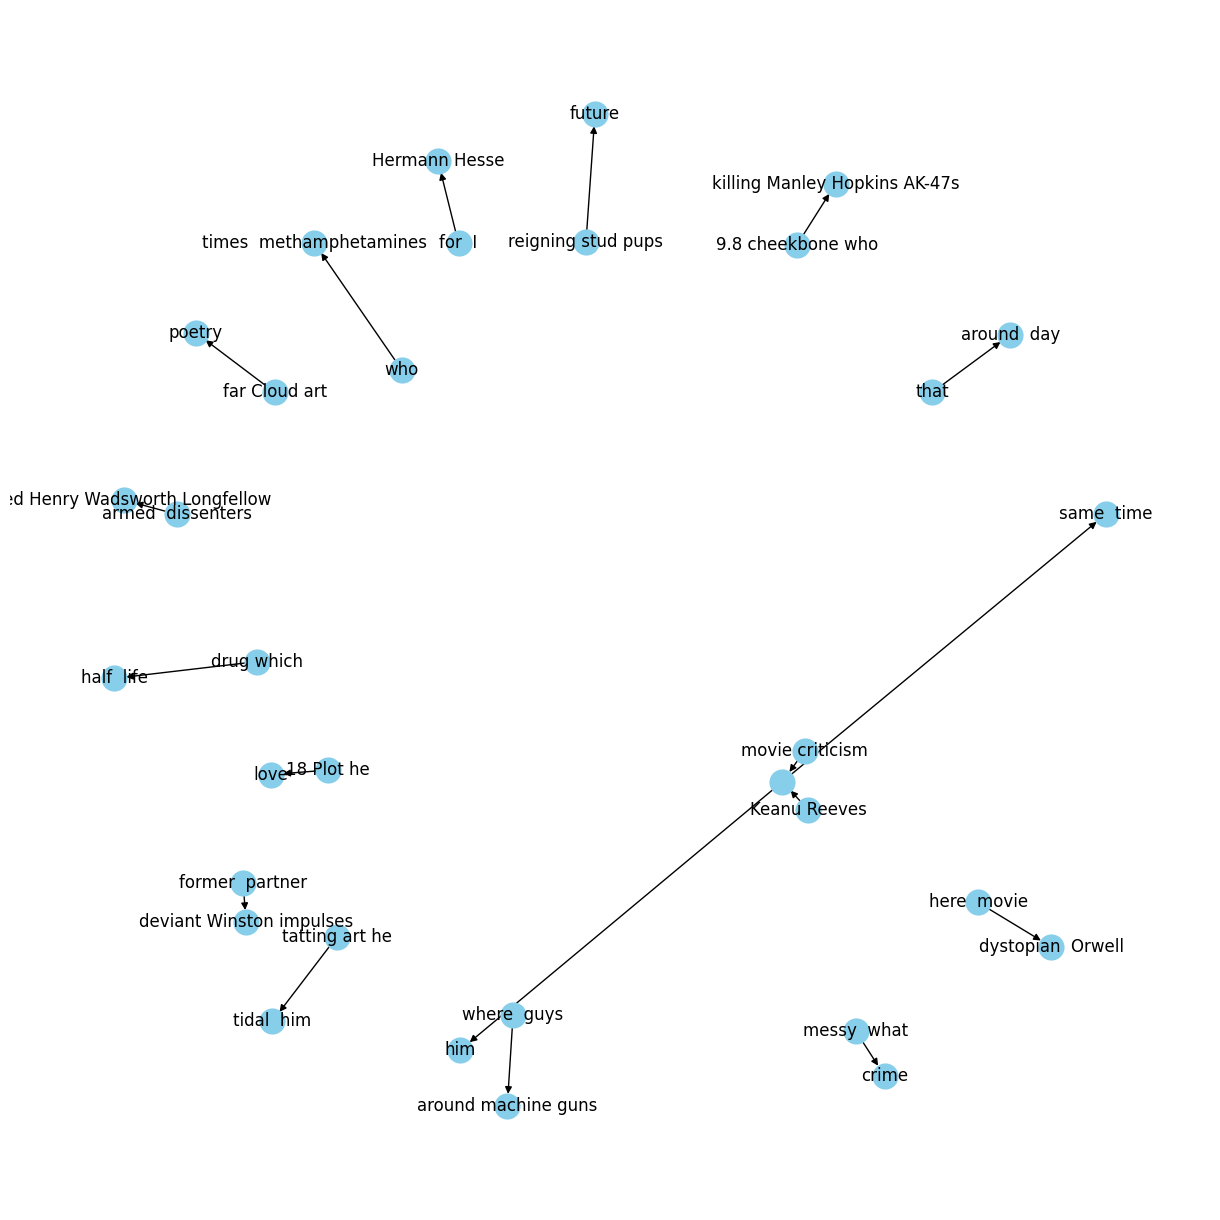

In [35]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True,
        node_color='skyblue',
        edge_cmap=plt.cm.Blues,
        pos=pos)

plt.show()

# All Reviews

So far we have worked with one review. We can now roll out the same method to plot the knowledge graph for the 10 reviews collected for the chosen movie.

## Explore entities and relations

In [36]:
movie_reviews

0    A tedious rip-off sci-fi film , itching to be ...
1    `` Equilibrium '' is like a remake of `` 1984 ...
2    An unsophisticated sci-fi drama that takes its...
3    Science fiction is a good genre for creating v...
4    The worst theatrically released sci-fi flick s...
5    Equilibrium is my favorite movie of 2002 . It ...
6    If I was to explain this movie to someone in o...
7    If you were disappointed by recent sci-fi acti...
8    `` Equilibrium '' would be a mindless action p...
9    In the first years of the 21st century , a thi...
Name: Text, dtype: object

Conceptually, this is no different from working on one review, we simply join all the reviews for the movie into one large string.

In [37]:
all_movie_reviews = ' '.join(movie_reviews)

In [38]:
doc = nlp(all_movie_reviews)

In [39]:
doc_sents = [str(x) for x in doc.sents]

First sentence

In [40]:
doc_sents[0]

"A tedious rip-off sci-fi film , itching to be another Matrix ( or , maybe just a bearable flick ! ) , that brazenly steals everything from Orwell 's 1984 novel and many other thinking man 's films , with the same Dystopian agenda , such as Fahrenheit 451 ."

Last sentence

In [41]:
doc_sents[-1]

'To counter this , there are also a few new concepts ,'

In [42]:
len(doc_sents)

175

In [43]:
entity_pairs = []

for i in tqdm(doc_sents):
  entity_pairs.append(get_entities(i))

100%|██████████| 175/175 [00:04<00:00, 41.94it/s]


In [44]:
relations = [get_relation(i) for i in tqdm(doc_sents)]

100%|██████████| 175/175 [00:06<00:00, 27.46it/s]


In [45]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})

In [46]:
# Move everything to lower case
kg_df.source = kg_df.source.str.lower()
kg_df.target = kg_df.target.str.lower()
kg_df.edge = kg_df.edge.str.lower()

# Filter out empties
kg_df = kg_df[kg_df.source != '']
kg_df = kg_df[kg_df.target != '']
kg_df = kg_df[kg_df.edge != ''].copy()

In [47]:
kg_df.shape

(144, 3)

In [69]:
kg_df

,source,target,edge
0,bearable that,such thinking fahrenheit,steals
1,metallic techno it,actual cgi effects,offers
2,nevertheless it,overall interest,fails
3,intentioned virtues,recent films,seen
4,it,tired genre,adds unneeded
7,thomas crown affair,ground,got
8,main action hero,humanist seriousness love,was miscast
9,stiff actions,self action hero,were
11,about sci fi melodrama,silly exercise,is
12,challenging it,controlled suppression,fails


In [48]:
# create a directed-graph from a dataframe
G = nx.from_pandas_edgelist(kg_df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())

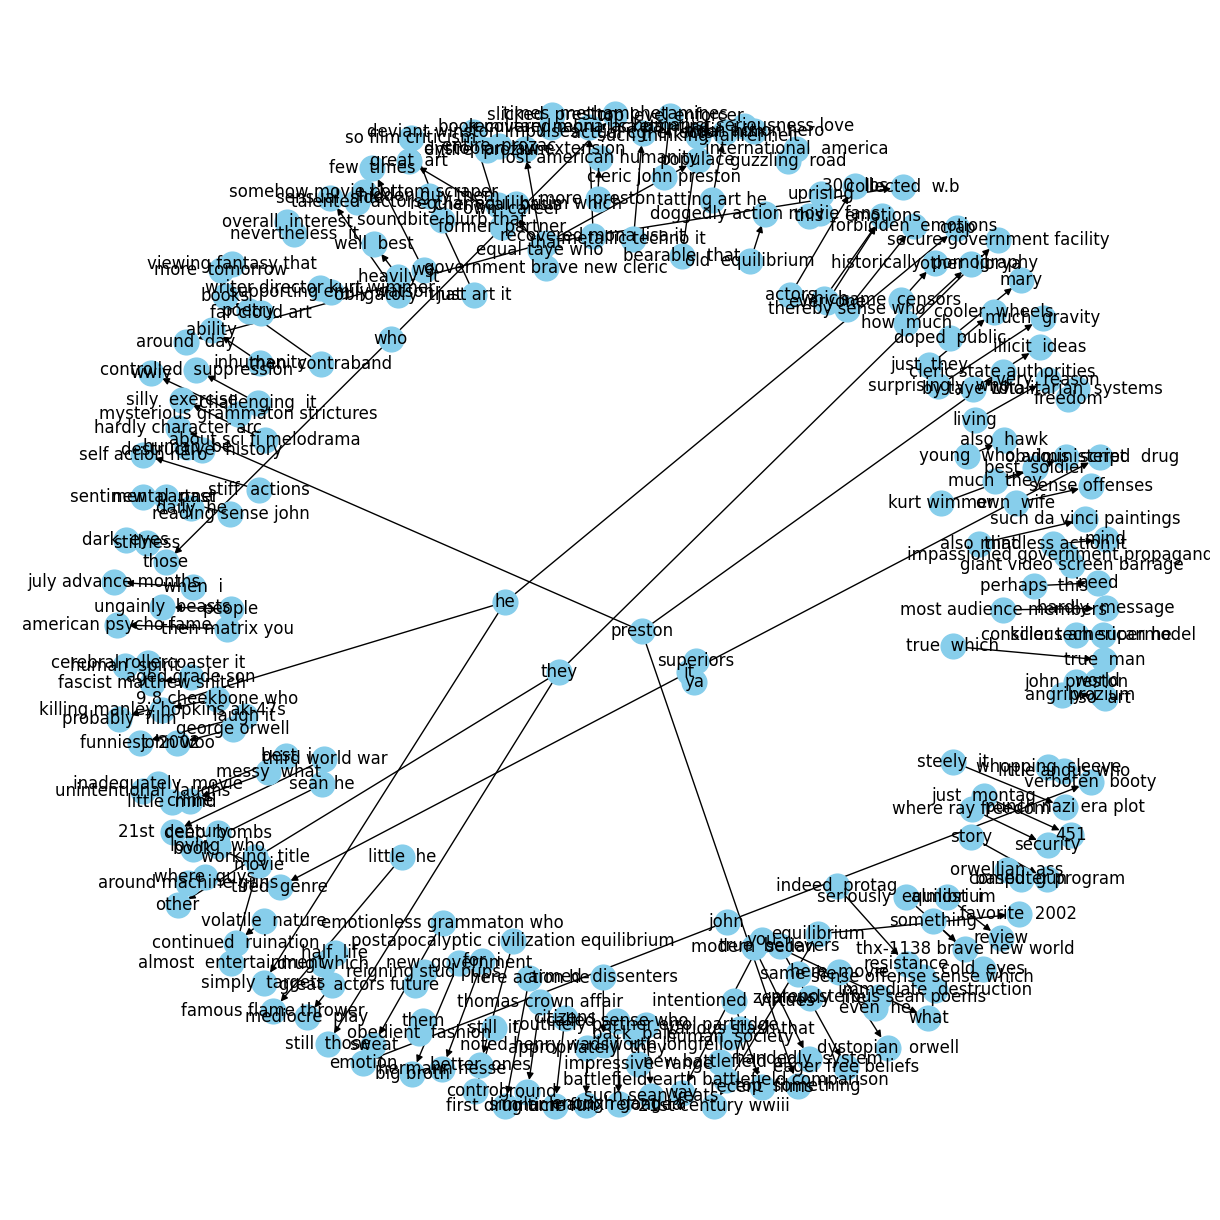

In [49]:

plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)

nx.draw(G, with_labels=True,
        node_color='skyblue',
        edge_cmap=plt.cm.Blues,
        pos=pos)

plt.show()

## Interesting relations

There are several relations to explore in the plot from the previous section. We could choose to focus on some relations that we find are particularly interesting.

In [50]:
pd.Series(relations).value_counts()[:50]

is                     17
are                     7
has                     5
be                      5
's                      4
takes                   3
was                     3
know                    3
decided                 2
.                       2
set in                  2
say                     2
forgets                 2
fails                   2
employed by special     1
hunt                    1
suppose                 1
stops                   1
went to                 1
seem                    1
Is                      1
designed                1
frightened by           1
steals                  1
plagued with            1
sticks                  1
portrays                1
notice                  1
's obvious              1
killed                  1
sit in                  1
keep                    1
patrol                  1
given                   1
injected with           1
thought about           1
misses                  1
presided                1
deals with  

We could zoom in on interesting relations from the list above.

In [51]:
RELATION_TO_EXPLORE = 'is'

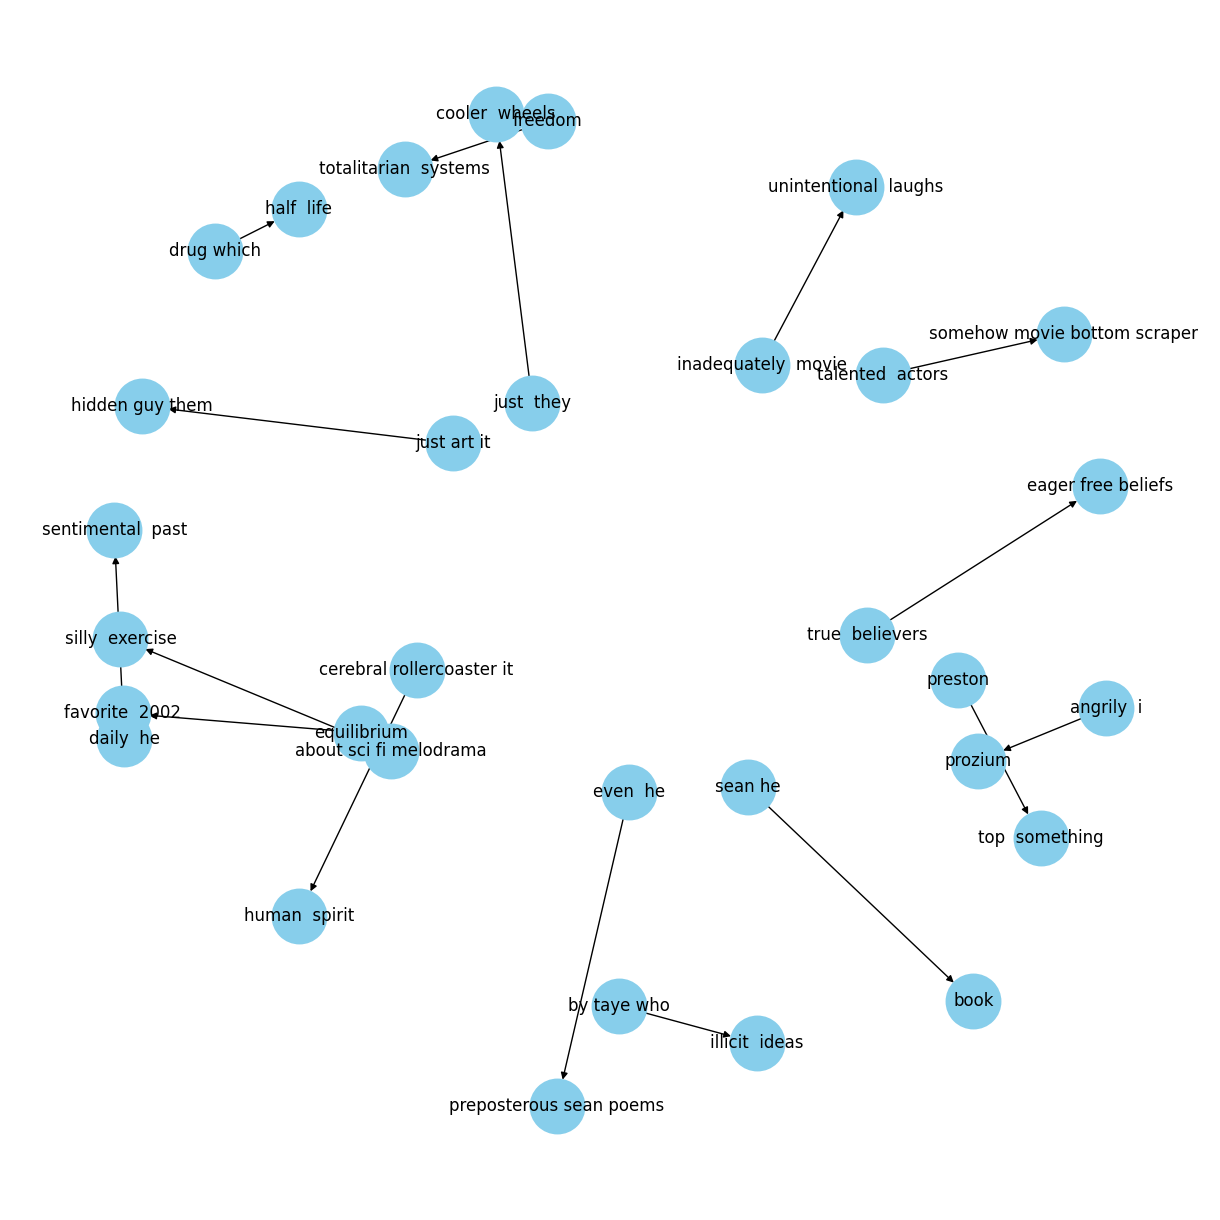

In [52]:
G = nx.from_pandas_edgelist(kg_df[kg_df['edge'] == RELATION_TO_EXPLORE],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='skyblue',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

## Interesting entities

Similary, we could zoom in on interesting entitites (say those identified from the manual ontology creation).

In [53]:
pd.set_option('display.max_rows', 500)
all_entities = kg_df['source'].tolist() + kg_df['target'].tolist()
frequency_counts = pd.Series(all_entities).value_counts()
frequency_counts

it                                          4
that                                        4
movie                                       3
preston                                     3
he                                          3
they                                        3
world                                       2
you                                         2
21st  century                               2
emotions                                    2
who                                         2
john                                        2
equilibrium                                 2
this                                        2
cold  eyes                                  1
hardly character arc                        1
favorite  2002                              1
hidden guy them                             1
killer tech supermodel                      1
preposterous sean poems                     1
dark  eyes                                  1
crap                              

In [54]:
len(frequency_counts)

266

Text(0, 0.5, 'Number of Entities')

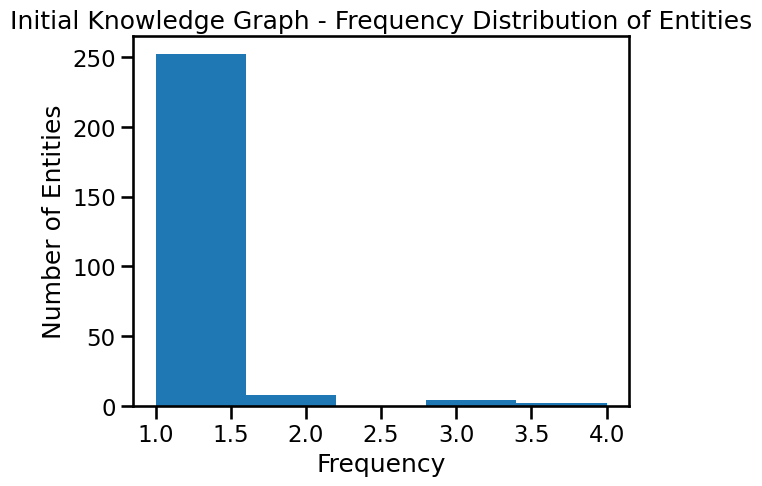

In [63]:
plt.hist(frequency_counts, bins=5)
plt.title('Initial Knowledge Graph - Frequency Distribution of Entities')
plt.xlabel('Frequency')
plt.ylabel('Number of Entities')

In [ ]:
plt.hist(frequency_counts, bins=30)
plt.title('Final Knowledge Graph - Frequency Distribution of Entities')
plt.xlabel('Frequency')
plt.ylabel('Number of Entities')

In [55]:
ENTITY_TO_EXPLORE = 'john preston'

In [56]:
entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)

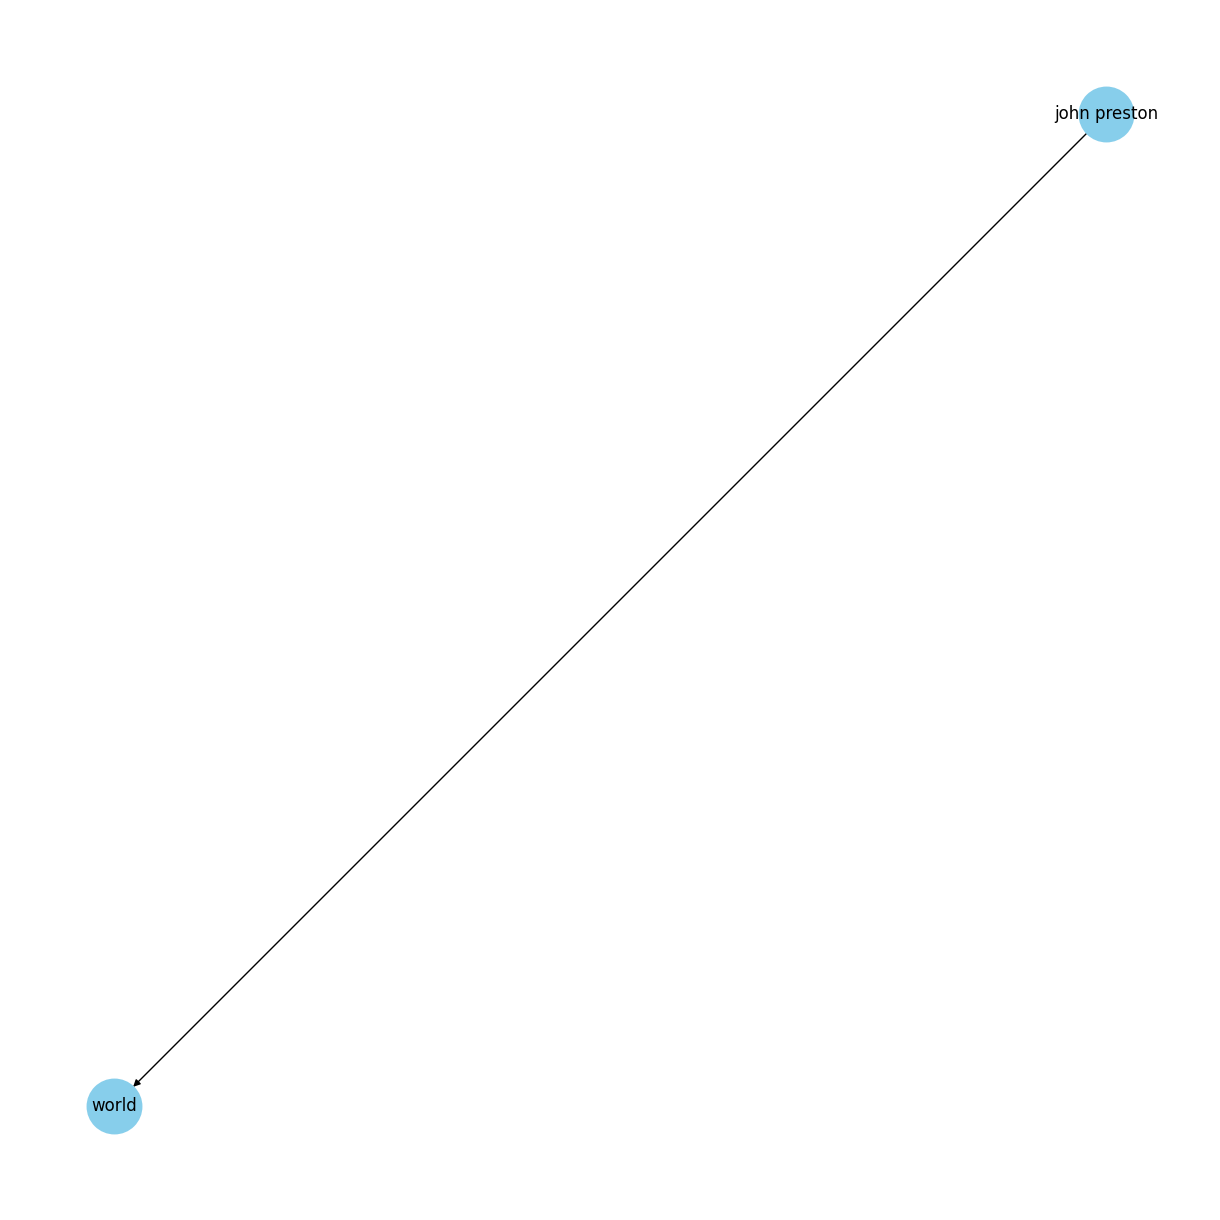

In [57]:


G = nx.from_pandas_edgelist(kg_df[entity_filter],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='skyblue',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

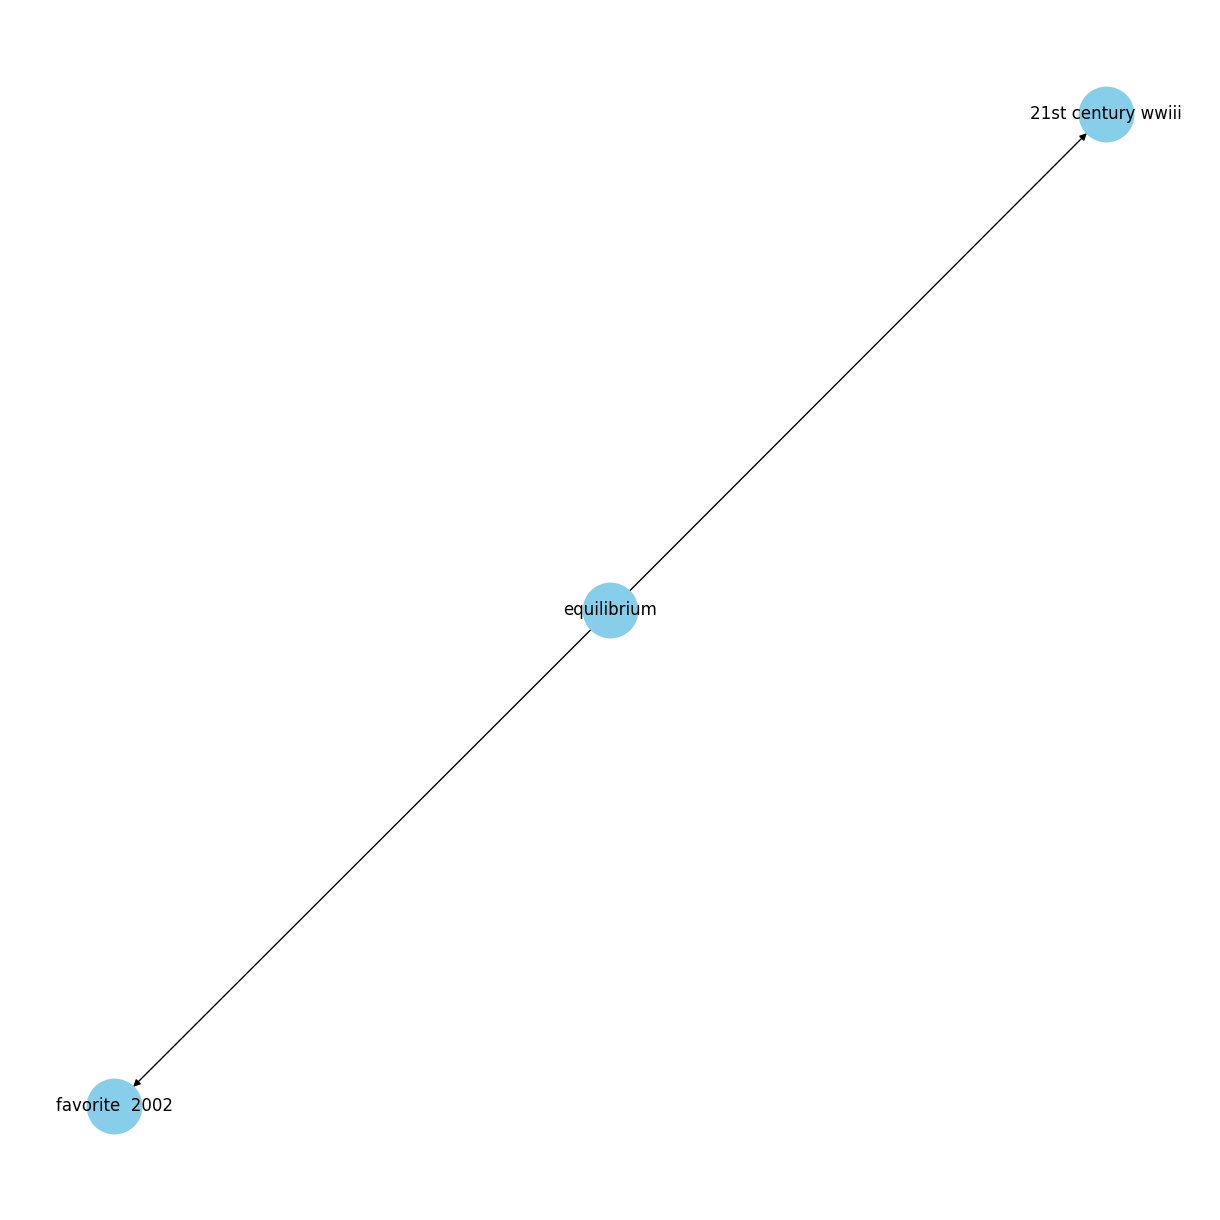

In [70]:
ENTITY_TO_EXPLORE = 'equilibrium'
entity_filter = (kg_df['source'] == ENTITY_TO_EXPLORE) | (kg_df['target'] == ENTITY_TO_EXPLORE)


G = nx.from_pandas_edgelist(kg_df[entity_filter],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='skyblue',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [58]:
new_kg_df = kg_df.copy()
term_mapper = {'john preston': ['john', 'preston']}

# Function to apply replacements based on substring matches
def replace_substring(cell, term_mapper):
    for key, values in term_mapper.items():
        for value in values:
            if value in cell:
                return key
    return cell

# Apply replacements for 'source' column
new_kg_df['source'] = new_kg_df['source'].apply(lambda x: replace_substring(x, term_mapper))

# Apply replacements for 'target' column
new_kg_df['target'] = new_kg_df['target'].apply(lambda x: replace_substring(x, term_mapper))

print(new_kg_df)

                                       source  \
0                              bearable  that   
1                          metallic techno it   
2                            nevertheless  it   
3                        intentioned  virtues   
4                                          it   
7                         thomas crown affair   
8                            main action hero   
9                              stiff  actions   
11                     about sci fi melodrama   
12                            challenging  it   
13                                equilibrium   
14                                       this   
15                                  daily  he   
16                               john preston   
17                                        who   
18                                where  guys   
20                                here  movie   
21                                       that   
22                                 drug which   
23                  

In [59]:
ENTITY_TO_EXPLORE = 'john preston'
new_entity_filter = (new_kg_df['source'] == ENTITY_TO_EXPLORE) | (new_kg_df['target'] == ENTITY_TO_EXPLORE)

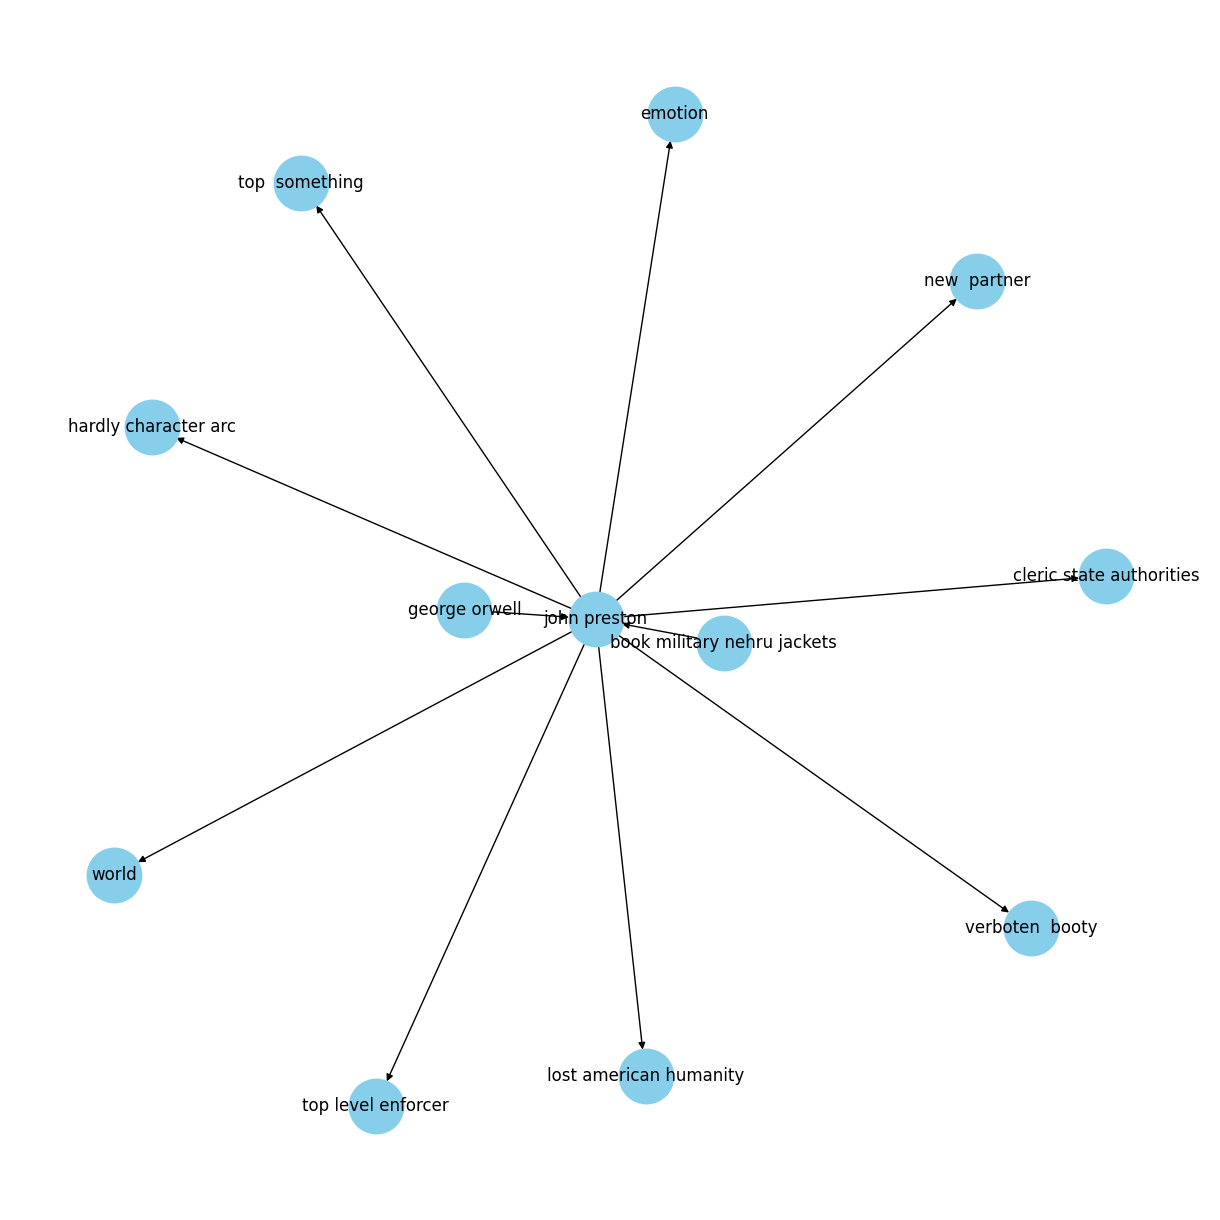

In [60]:


G = nx.from_pandas_edgelist(new_kg_df[new_entity_filter],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='skyblue',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

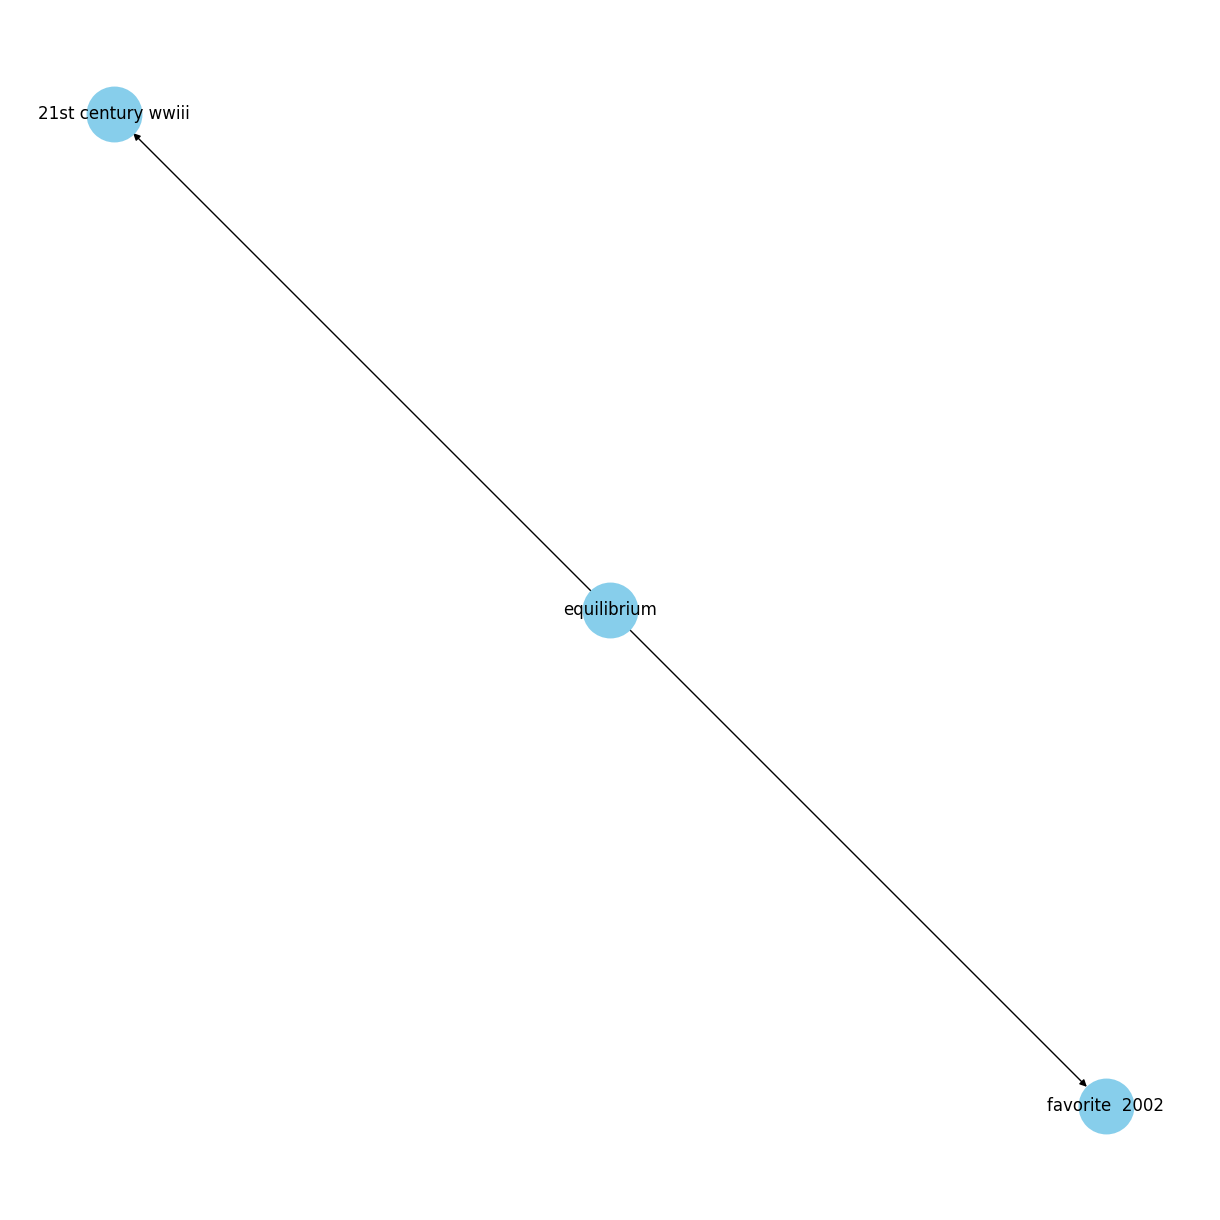

In [67]:

ENTITY_TO_EXPLORE = 'equilibrium'
new_entity_filter = (new_kg_df['source'] == ENTITY_TO_EXPLORE) | (new_kg_df['target'] == ENTITY_TO_EXPLORE)
G = nx.from_pandas_edgelist(new_kg_df[new_entity_filter],
                            "source", "target",
                            edge_attr=True,
                            create_using=nx.MultiDiGraph())

plt.figure(figsize=(12, 12))

pos = nx.spring_layout(G, k=0.5) # k regulates the distance between nodes

nx.draw(G, with_labels=True,
        node_color='skyblue',
        node_size=1500, edge_cmap=plt.cm.Blues, pos=pos)

plt.show()

In [68]:
pd.set_option('display.max_rows', 500)
all_entities = new_kg_df['source'].tolist() + new_kg_df['target'].tolist()
pd.Series(all_entities).value_counts()[:250]

john preston                                11
it                                           4
that                                         4
movie                                        3
they                                         3
he                                           3
this                                         2
world                                        2
you                                          2
21st  century                                2
who                                          2
emotions                                     2
equilibrium                                  2
cold  eyes                                   1
favorite  2002                               1
hidden guy them                              1
killer tech supermodel                       1
preposterous sean poems                      1
crap                                         1
dark  eyes                                   1
somehow movie bottom scraper                 1
451          

# Next Steps

- Identify and merge equivalence classes in the entities extracted.
- Explore few interesting relations and entities.

# Reference

https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook